# Part I: Gradient-Enhanced Polynomial Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
training_data = np.loadtxt('trainingIa.dat')
validation_data = np.loadtxt('validationIa.dat')

X_train, y_train = training_data[:, 0], training_data[:, 1]
X_val, y_val = validation_data[:, 0], validation_data[:, 1]

## I.a) Polynomial Regression -->

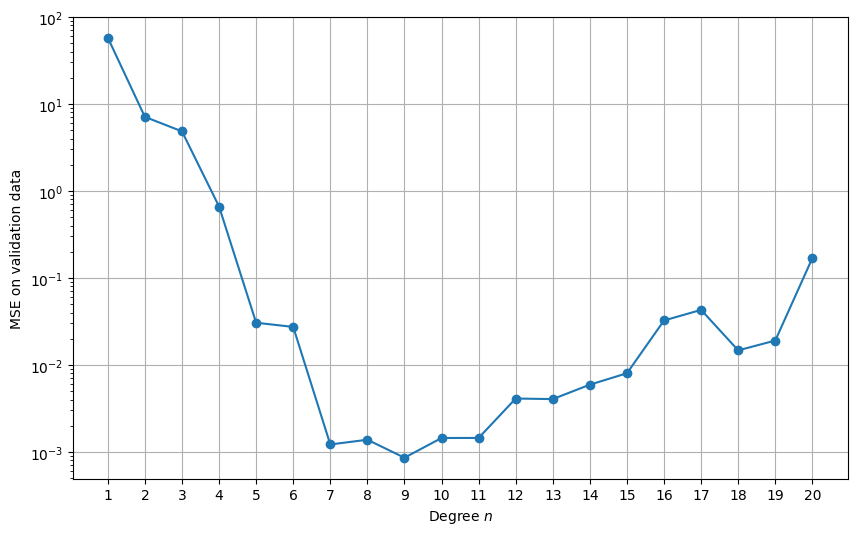

In [2]:
def solve_poly_regression(X, y, n):
    A = np.vander(X, n + 1, increasing=True)
    return np.linalg.lstsq(A, y, rcond=None)[0]

def mse(X, y, theta):
    n = len(theta) - 1
    A = np.vander(X, n + 1, increasing=True) # gives A with columns [1, X, X^2, ..., X^n]
    return np.mean((y - A @ theta)**2)

mses = []
for n in range(1, 21):
    theta = solve_poly_regression(X_train, y_train, n)
    mses.append(mse(X_val, y_val, theta))

mses = np.array(mses)

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, 21), mses, marker='o')
plt.xticks(range(1, 21))  # integer x-axis ticks 1,2,3+...
plt.xlabel(r'Degree $n$')
plt.ylabel(r'MSE on validation data')
#plt.title(r'MSE vs. Polynomial Degree')
plt.grid(True)
plt.savefig('plots/mse_vs_degree.png', bbox_inches='tight', dpi=600)
plt.show()

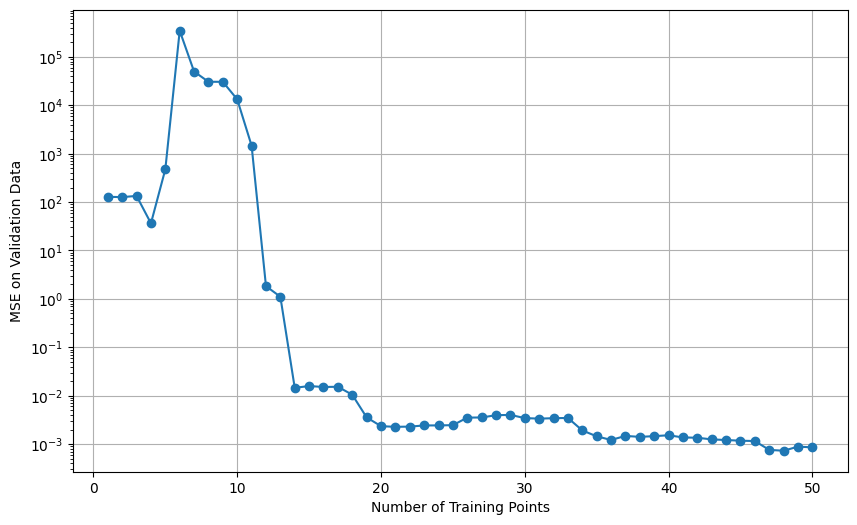

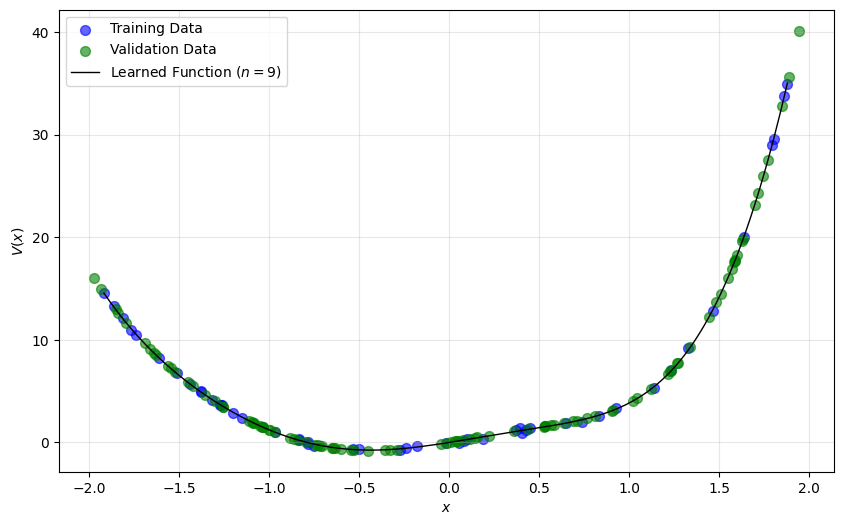

In [3]:
# MSE vs Number of Training Points for fixed n
n_fixed = 9
training_sizes_a = range(1, len(X_train) + 1, 1)
mses_vs_size_a = []

for size in training_sizes_a:
    X_subset = X_train[:size]
    y_subset = y_train[:size]
    theta_subset = solve_poly_regression(X_subset, y_subset, n_fixed)
    mses_vs_size_a.append(mse(X_val, y_val, theta_subset))

plt.figure(figsize=(10, 6))
plt.plot(training_sizes_a, mses_vs_size_a, marker='o')
plt.xlabel(r'Number of Training Points')
plt.ylabel(r'MSE on Validation Data')
plt.yscale('log')
#plt.title(rf'MSE vs. Number of Training Points (Fixed $n={n_fixed}$)')
plt.grid(True)
plt.savefig('plots/mse_vs_training_size_a.png', bbox_inches='tight', dpi=600)
plt.show()

# Show the learned function at the best n
theta_best_a = solve_poly_regression(X_train, y_train, n_fixed)
x_plot = np.linspace(X_train.min(), X_train.max(), 200)
A_plot = np.vander(x_plot, n_fixed + 1, increasing=True)
y_plot = A_plot @ theta_best_a

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.6, s=50)
plt.scatter(X_val, y_val, color='green', label='Validation Data', alpha=0.6, s=50)
plt.plot(x_plot, y_plot, '-', color='black', linewidth=1, label=rf'Learned Function ($n={n_fixed}$)')
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')
#plt.title(rf'Learned Polynomial Function ($n={n_fixed}$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/learned_function_a.png', bbox_inches='tight', dpi=600)
plt.show()

## I.b) Gradient-Enhanced Polynomial Regression

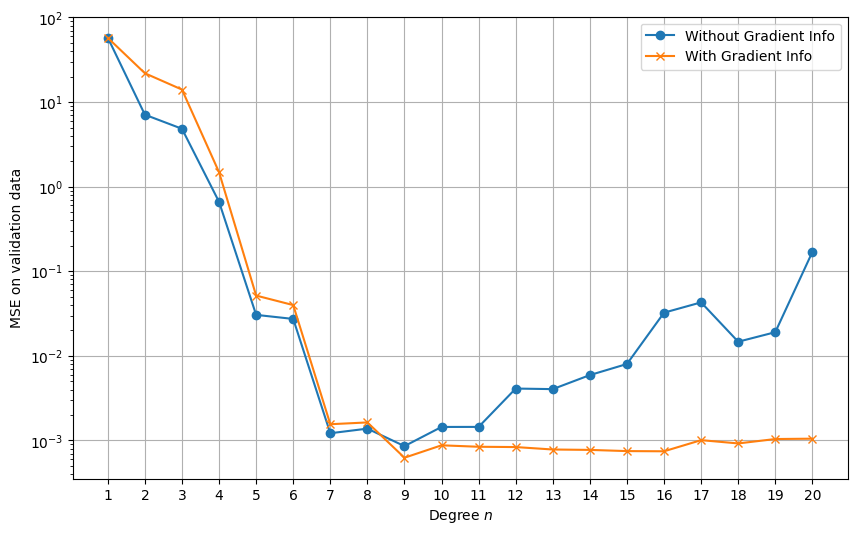

In [4]:
# Load the new data
training_data_b = np.loadtxt('trainingIb.dat')

X_train_b, y_train_b, dy_train_b = training_data_b[:, 0], training_data_b[:, 1], training_data_b[:, 2]

def solve_grad_poly_regression(X, y, dy, n):
    A_fit = np.vander(X, n + 1, increasing=True)
    A_grad = np.vander(X, n, increasing=True) * np.arange(1, n + 1)
    A_grad = np.c_[np.zeros(A_grad.shape[0]), A_grad]
    A = np.vstack([A_fit, A_grad])
    b = np.concatenate([y, dy])
    return np.linalg.lstsq(A, b, rcond=None)[0] # Solves Ax = b

mses_b = []
for n in range(1, 21):
    theta_b = solve_grad_poly_regression(X_train_b, y_train_b, dy_train_b, n)
    mses_b.append(mse(X_val, y_val, theta_b))

mses_b = np.array(mses_b)

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, 21), mses, marker='o', label=r'Without Gradient Info')
plt.semilogy(range(1, 21), mses_b, marker='x', label=r'With Gradient Info')
plt.xticks(range(1, 21))  # make x-axis ticks 1,2,3+...
plt.xlabel(r'Degree $n$')
plt.ylabel(r'MSE on validation data')
#plt.title(r'MSE vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.savefig('plots/mse_comparison.png', bbox_inches='tight', dpi=600)
plt.show()

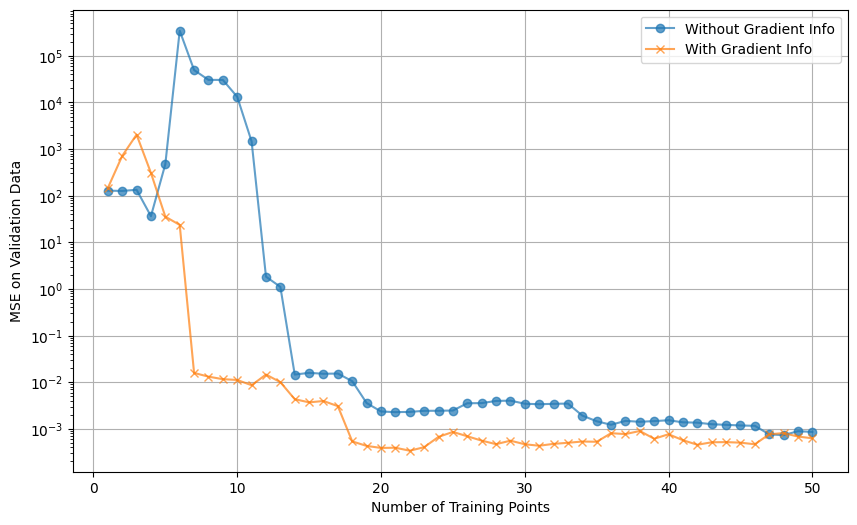

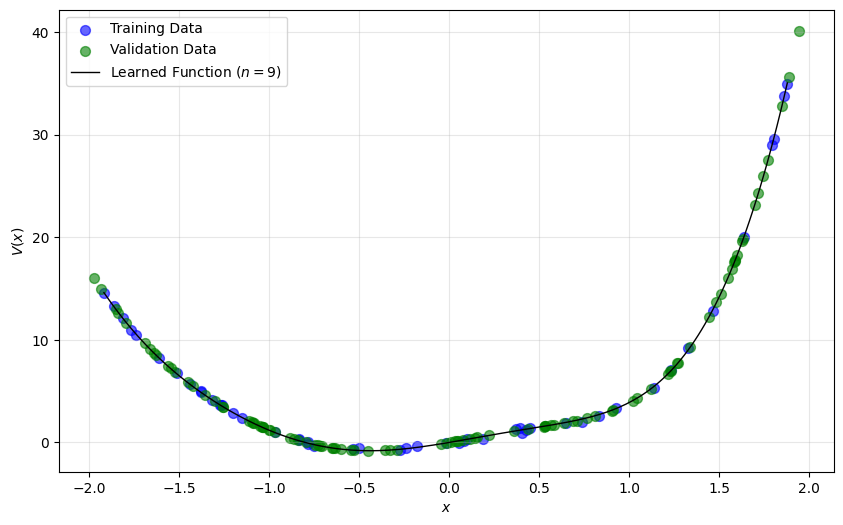

In [5]:
best_n_b = 9
training_sizes = range(1, len(X_train_b) + 1, 1)

# With gradient info
mses_vs_size_grad = []
for size in training_sizes:
    X_subset = X_train_b[:size]
    y_subset = y_train_b[:size]
    dy_subset = dy_train_b[:size]
    theta_subset = solve_grad_poly_regression(X_subset, y_subset, dy_subset, n_fixed)
    mses_vs_size_grad.append(mse(X_val, y_val, theta_subset))

# Without gradient info (from I.a data, same n)
mses_vs_size_no_grad = []
for size in training_sizes:
    X_subset = X_train[:size]
    y_subset = y_train[:size]
    theta_subset = solve_poly_regression(X_subset, y_subset, n_fixed)
    mses_vs_size_no_grad.append(mse(X_val, y_val, theta_subset))

plt.figure(figsize=(10, 6))
plt.plot(training_sizes, mses_vs_size_no_grad, marker='o', label='Without Gradient Info', alpha=0.7)
plt.plot(training_sizes, mses_vs_size_grad, marker='x', label='With Gradient Info', alpha=0.7)
plt.xlabel('Number of Training Points')
plt.ylabel('MSE on Validation Data')
plt.yscale('log')
#plt.title(rf'MSE vs. Number of Training Points (Fixed $n={n_fixed}$)')
plt.legend()
plt.grid(True)
plt.savefig('plots/mse_vs_training_size_comparison.png', bbox_inches='tight', dpi=600)
plt.show()

# Show the learned function at the best n
theta_best_b = solve_grad_poly_regression(X_train_b, y_train_b, dy_train_b, best_n_b)

# Generate points for smooth plotting
x_plot = np.linspace(X_train_b.min(), X_train_b.max(), 200)
A_plot = np.vander(x_plot, best_n_b + 1, increasing=True)
y_plot = A_plot @ theta_best_b

plt.figure(figsize=(10, 6))
plt.scatter(X_train_b, y_train_b, color='blue', label='Training Data', alpha=0.6, s=50)
plt.scatter(X_val, y_val, color='green', label='Validation Data', alpha=0.6, s=50)
plt.plot(x_plot, y_plot, '-', color='black', linewidth=1, label=rf'Learned Function ($n={best_n_b}$)')
plt.xlabel(r'$x$')
plt.ylabel(r'$V(x)$')
#plt.title(rf'Learned Polynomial Function with Gradient Information ($n={best_n_b}$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('plots/learned_function_with_gradient.png', bbox_inches='tight', dpi=600)
plt.show()

# Part II: A First Approach to Dynamic Optimisation

## II.a) Regularized Least Squares

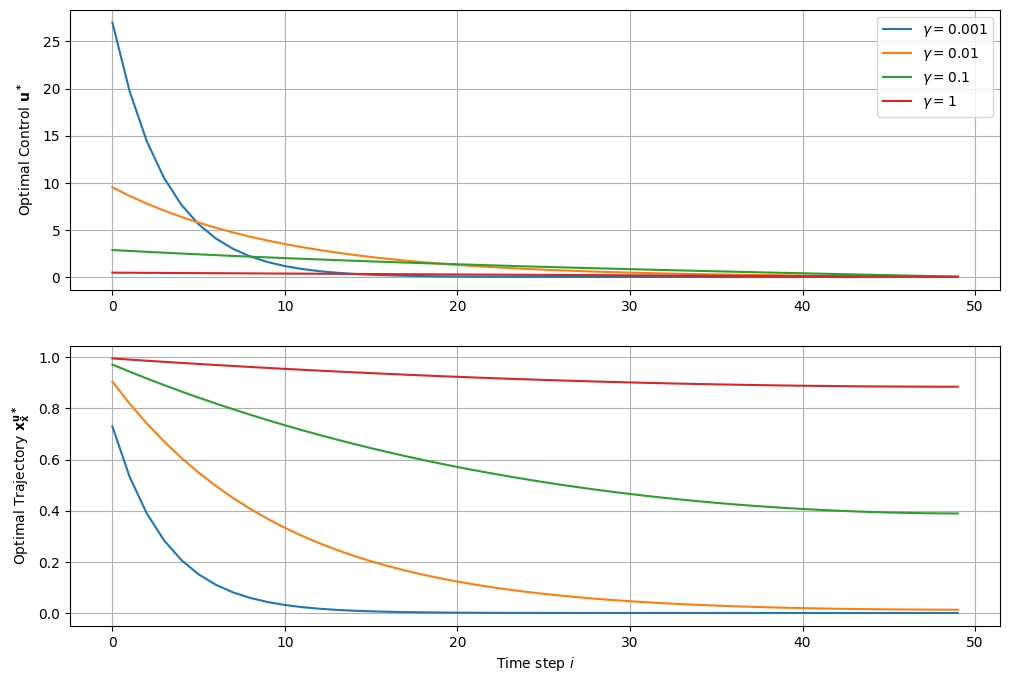

In [6]:
N = 50
x0 = 1
a = 1
b = -0.01
x_bar = 1
gammas = [1e-3, 1e-2, 0.1, 1]

S = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        S[i, j] = b * (a ** (i - j))

c = np.zeros(N)
for i in range(N):
    c[i] = (a ** (i + 1)) * x0

plt.figure(figsize=(12, 8))

for gamma in gammas:
    u = np.linalg.solve(S.T @ S + gamma * np.eye(N), -S.T @ c)
    x = S @ u + c
    
    plt.subplot(2, 1, 1)
    plt.plot(u, label=rf'$\gamma = {gamma}$')
    plt.ylabel(r'Optimal Control $\mathbf{u^*}$')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(x, label=rf'$\gamma = {gamma}$')
    plt.ylabel(r'Optimal Trajectory $\mathbf{x_{\bar{x}}^{u*}}$')
    plt.xlabel(r'Time step $i$')
    plt.grid(True)

plt.savefig('plots/dynamic_optimisation_a.png', bbox_inches='tight', dpi=600)
plt.show()

## II.b) Coupled System

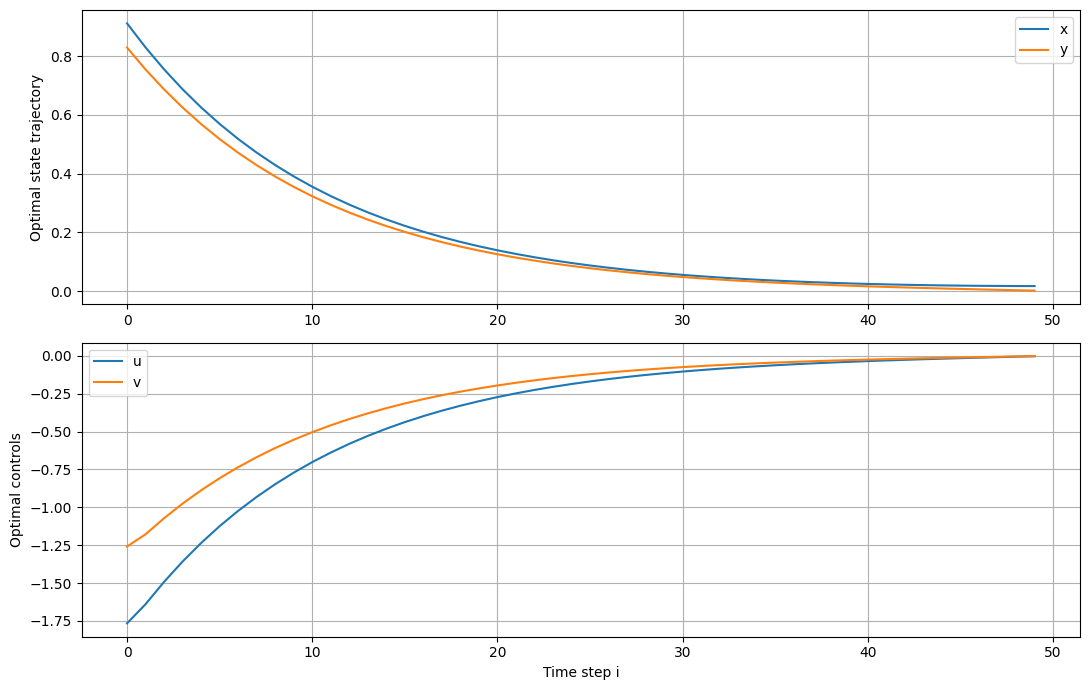

In [7]:
N = 50
a = 1
b = 0.05
x0 = 1
c_param = 0.2
d = -0.5
y0 = 1
gamma = 1

Sx = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        Sx[i, j] = b * (a ** (i - j))

cx = np.zeros(N)
for i in range(N):
    cx[i] = (a ** (i + 1)) * x0

Sy = np.zeros((N, N))
for i in range(N):
    for j in range(i + 1):
        Sy[i, j] = d * (c_param ** (i - j))

cy = np.zeros(N)
for i in range(N):
    cy[i] = (c_param ** (i + 1)) * y0

A = Sx.T @ Sx + gamma * np.eye(N)
B = -gamma * np.eye(N)
C = -gamma * np.eye(N)
D_mat = Sy.T @ Sy + gamma * np.eye(N)

LHS = np.block([[A, B], [C, D_mat]])
RHS = np.concatenate([-Sx.T @ cx, -Sy.T @ cy])

sol = np.linalg.solve(LHS, RHS)
u = sol[:N]
v = sol[N:]

x = Sx @ u + cx
y = Sy @ v + cy

plt.figure(figsize=(11, 7))

# --- Top plot: states ---
plt.subplot(2, 1, 1)
plt.plot(x, label='x')
plt.plot(y, label='y')
plt.ylabel('Optimal state trajectory')
plt.legend()
plt.grid(True)

# --- Bottom plot: controls ---
plt.subplot(2, 1, 2)
plt.plot(u, label='u')
plt.plot(v, label='v')
plt.xlabel('Time step i')
plt.ylabel('Optimal controls')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('plots/dynamic_optimisation_b.png', bbox_inches='tight', dpi=600)
plt.show()

## II.c) Pareto Front

In [8]:
gammas = 10 ** np.arange(-5, 5.1, 0.1)

exps = np.log10(gammas)
steps = np.diff(exps)

print(steps[:5])

[0.1 0.1 0.1 0.1 0.1]


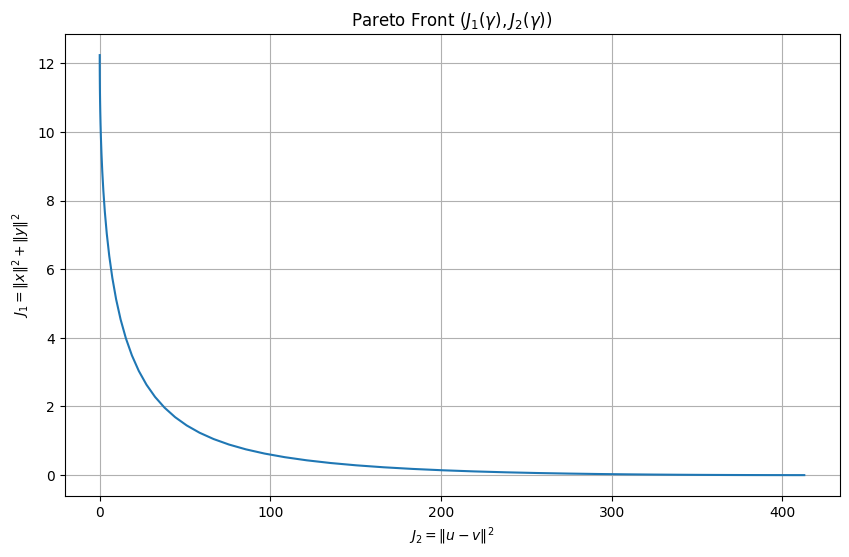

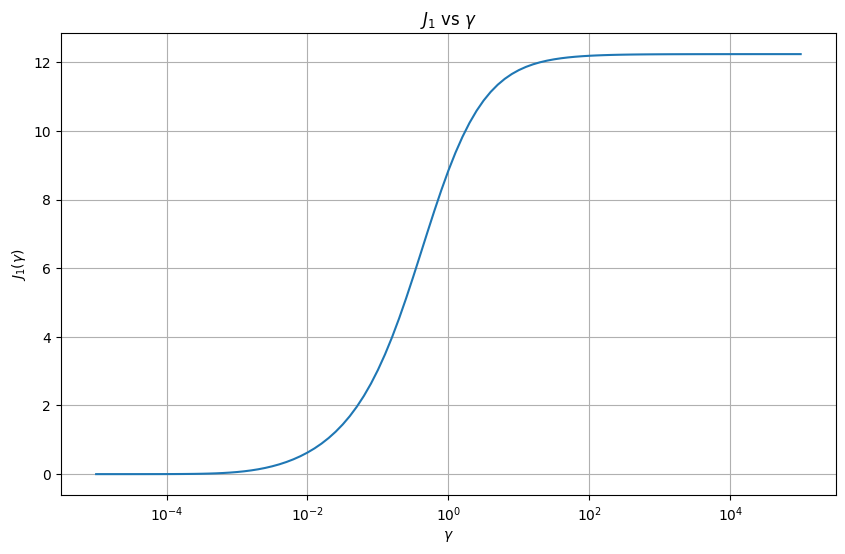

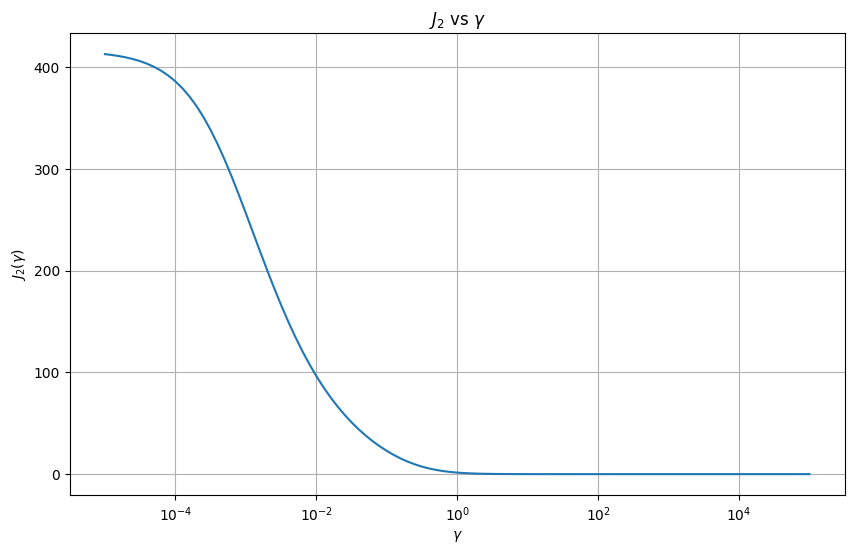

In [9]:
J1s = []
J2s = []

for gamma in gammas:
    A = Sx.T @ Sx + gamma * np.eye(N)
    B = -gamma * np.eye(N)
    C = -gamma * np.eye(N)
    D_mat = Sy.T @ Sy + gamma * np.eye(N)

    LHS = np.block([[A, B], [C, D_mat]])
    RHS = np.concatenate([-Sx.T @ cx, -Sy.T @ cy])

    sol = np.linalg.solve(LHS, RHS)
    u = sol[:N]
    v = sol[N:]

    x = Sx @ u + cx
    y = Sy @ v + cy

    J1 = np.linalg.norm(x)**2 + np.linalg.norm(y)**2
    J2 = np.linalg.norm(u - v)**2

    J1s.append(J1)
    J2s.append(J2)

plt.figure(figsize=(10, 6))
plt.plot(J2s, J1s)
plt.xlabel(r'$J_2 = \|u - v\|^2$')
plt.ylabel(r'$J_1 = \|x\|^2 + \|y\|^2$')
plt.title(r'Pareto Front $(J_1(\gamma), J_2(\gamma))$')
plt.grid(True)
plt.savefig('plots/pareto_front.png', bbox_inches='tight', dpi=600)
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(gammas, J1s, label=r'$J_1$: State Error')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$J_1(\gamma)$')
plt.title(r'$J_1$ vs $\gamma$')
plt.grid(True)
plt.savefig('plots/j1_vs_gamma.png', bbox_inches='tight', dpi=600)
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogx(gammas, J2s, label=r'$J_2$: Control Difference')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$J_2(\gamma)$')
plt.title(r'$J_2$ vs $\gamma$')
plt.grid(True)
plt.savefig('plots/j2_vs_gamma.png', bbox_inches='tight', dpi=600)
plt.show()

## II.d) L1-norm regularisation

In [10]:
def grad_L_epsilon(z, epsilon):
    """
    Compute gradient of L_epsilon(z) where:
    L_epsilon(z) = (1/2)*z^2 if |z| <= epsilon
                 = epsilon*(|z| - epsilon/2) otherwise
    
    The gradient is:
    dL/dz = z if |z| <= epsilon
          = epsilon*sign(z) otherwise
    """
    grad = np.zeros_like(z)
    idx = np.abs(z) <= epsilon
    grad[idx] = z[idx]  # Quadratic region
    grad[~idx] = epsilon * np.sign(z[~idx])  # Linear region
    return grad

def gradient_descent(u_init=np.zeros(N), v_init=np.zeros(N), gamma1=1., gamma2=1., epsilon=1., lr=1e-4, n_iter=10000):
    u = u_init.copy()
    v = v_init.copy()
    
    for _ in range(n_iter):
        # Gradient w.r.t. u
        grad_u = 2 * Sx.T @ (Sx @ u + cx) + 2 * gamma2 * (u - v) + gamma1 * grad_L_epsilon(u - v, epsilon)
        
        # Gradient w.r.t. v
        grad_v = 2 * Sy.T @ (Sy @ v + cy) - 2 * gamma2 * (u - v) - gamma1 * grad_L_epsilon(u - v, epsilon)
        
        u -= lr * grad_u
        v -= lr * grad_v
        
    return u, v

### Learning Rate Optimization

Testing different learning rates to find the optimal value for convergence.


Case (i)
--------------------------------------------------
LR: 1.0e-05, Cost: 34.580654
LR: 5.0e-05, Cost: 17.706438
LR: 1.0e-04, Cost: 13.598901
LR: 5.0e-04, Cost: 10.487646
LR: 1.0e-03, Cost: 10.354384
LR: 5.0e-03, Cost: 10.341516
LR: 1.0e-02, Cost: 10.341515
LR: 5.0e-02, Cost: 10.341515
LR: 1.0e-01, Cost: 10.341515
Optimal LR: 1.0e-01, Min Cost: 10.341515

Case (ii)
--------------------------------------------------
LR: 1.0e-05, Cost: 33.944855
LR: 5.0e-05, Cost: 15.328222
LR: 1.0e-04, Cost: 11.974831
LR: 5.0e-04, Cost: 9.272865
LR: 1.0e-03, Cost: 9.116767
LR: 5.0e-03, Cost: 9.099623
LR: 1.0e-02, Cost: 9.099623
LR: 5.0e-02, Cost: 9.099623
LR: 1.0e-01, Cost: 9.099623
Optimal LR: 1.0e-01, Min Cost: 9.099623

Case (iii)
--------------------------------------------------
LR: 1.0e-05, Cost: 33.828914
LR: 5.0e-05, Cost: 12.646245
LR: 1.0e-04, Cost: 8.735922
LR: 5.0e-04, Cost: 4.937803
LR: 1.0e-03, Cost: 3.934435
LR: 5.0e-03, Cost: 2.622455
LR: 1.0e-02, Cost: 2.323346
LR: 5.0e-02, Cost: 

C:\Users\Umar\AppData\Local\Temp\ipykernel_19076\3300812458.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=10)


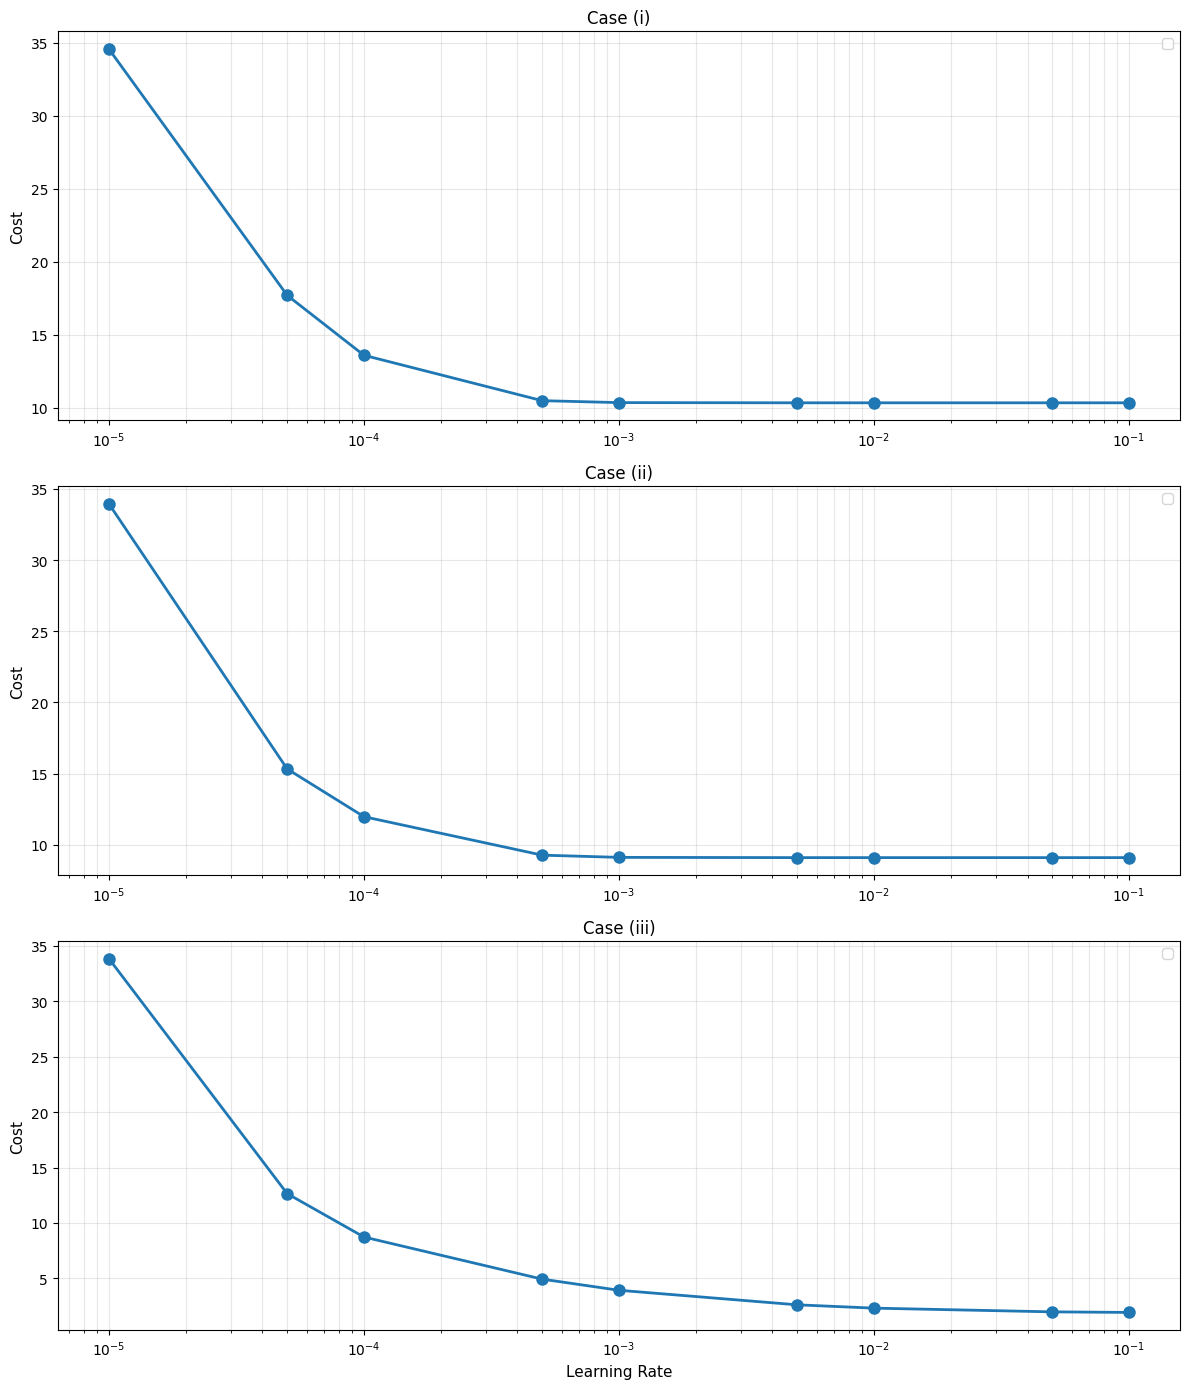


SUMMARY: Optimal Learning Rates (based on full cost)
Case (i)
  Optimal LR: 1.0e-01, Min Cost: 10.341515
Case (ii)
  Optimal LR: 1.0e-01, Min Cost: 9.099623
Case (iii)
  Optimal LR: 1.0e-01, Min Cost: 1.936259


In [13]:
# Helper function for the L_epsilon cost component
def L_epsilon_cost(z, epsilon):
    """Computes the L_epsilon approximation of the L1 norm cost."""
    cost = np.zeros_like(z)
    idx = np.abs(z) <= epsilon
    # Quadratic part for |z| <= epsilon
    cost[idx] = 0.5 * z[idx]**2
    # Linear part for |z| > epsilon
    cost[~idx] = epsilon * (np.abs(z[~idx]) - 0.5 * epsilon)
    return np.sum(cost)

# Helper function for the full objective function
def calculate_full_cost(u, v, x, y, gamma1, gamma2, epsilon):
    """Calculates the full objective function value from problem II.d)."""
    cost_state = np.linalg.norm(x)**2 + np.linalg.norm(y)**2
    cost_l2_control_diff = gamma2 * np.linalg.norm(u - v)**2
    cost_l1_control_diff = gamma1 * L_epsilon_cost(u - v, epsilon)
    return cost_state + cost_l2_control_diff + cost_l1_control_diff

# Test different learning rates to find optimal value for all three cases
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
test_iterations = 5000

# Test cases: (gamma1, gamma2, epsilon, label)
test_cases = [
    (0, 1, 1, 'Case (i)'),
    (1, 0, 1, 'Case (ii)'),
    (1, 0, 0.1, 'Case (iii)')
]

all_costs = []
optimal_lrs = []

# Test each case
for gamma1, gamma2, epsilon, label in test_cases:
    costs = []
    print(f"\n{label}")
    print("-" * 50)
    
    for test_lr in learning_rates:
        u_test, v_test = gradient_descent(
            gamma1=gamma1, gamma2=gamma2, epsilon=epsilon, 
            lr=test_lr, n_iter=test_iterations
        )
        x_test = Sx @ u_test + cx
        y_test = Sy @ v_test + cy
        
        # Calculate the FULL objective function value
        cost = calculate_full_cost(u_test, v_test, x_test, y_test, gamma1, gamma2, epsilon)
        
        costs.append(cost)
        print(f"LR: {test_lr:.1e}, Cost: {cost:.6f}")
    
    all_costs.append(costs)
    optimal_lr = learning_rates[np.argmin(costs)]
    optimal_lrs.append(optimal_lr)
    print(f"Optimal LR: {optimal_lr:.1e}, Min Cost: {min(costs):.6f}")

# Plot all results in one figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

for idx, (costs, (gamma1, gamma2, epsilon, label), opt_lr) in enumerate(zip(all_costs, test_cases, optimal_lrs)):
    ax = axes[idx]
    ax.semilogx(learning_rates, costs, marker='o', linewidth=2, markersize=8)

    # plot x-axis for last plot only
    if idx == 2:
        ax.set_xlabel(r'Learning Rate', fontsize=11)
    ax.set_ylabel(r'Cost', fontsize=11)
    ax.set_title(label, fontsize=12)
    ax.grid(True, which='both', alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('plots/learning_rate_comparison.png', bbox_inches='tight', dpi=600)
plt.show()

# Summary
print("\n" + "="*50)
print("SUMMARY: Optimal Learning Rates (based on full cost)")
print("="*50)
for (gamma1, gamma2, epsilon, label), opt_lr, costs in zip(test_cases, optimal_lrs, all_costs):
    print(f"{label}")
    print(f"  Optimal LR: {opt_lr:.1e}, Min Cost: {min(costs):.6f}")

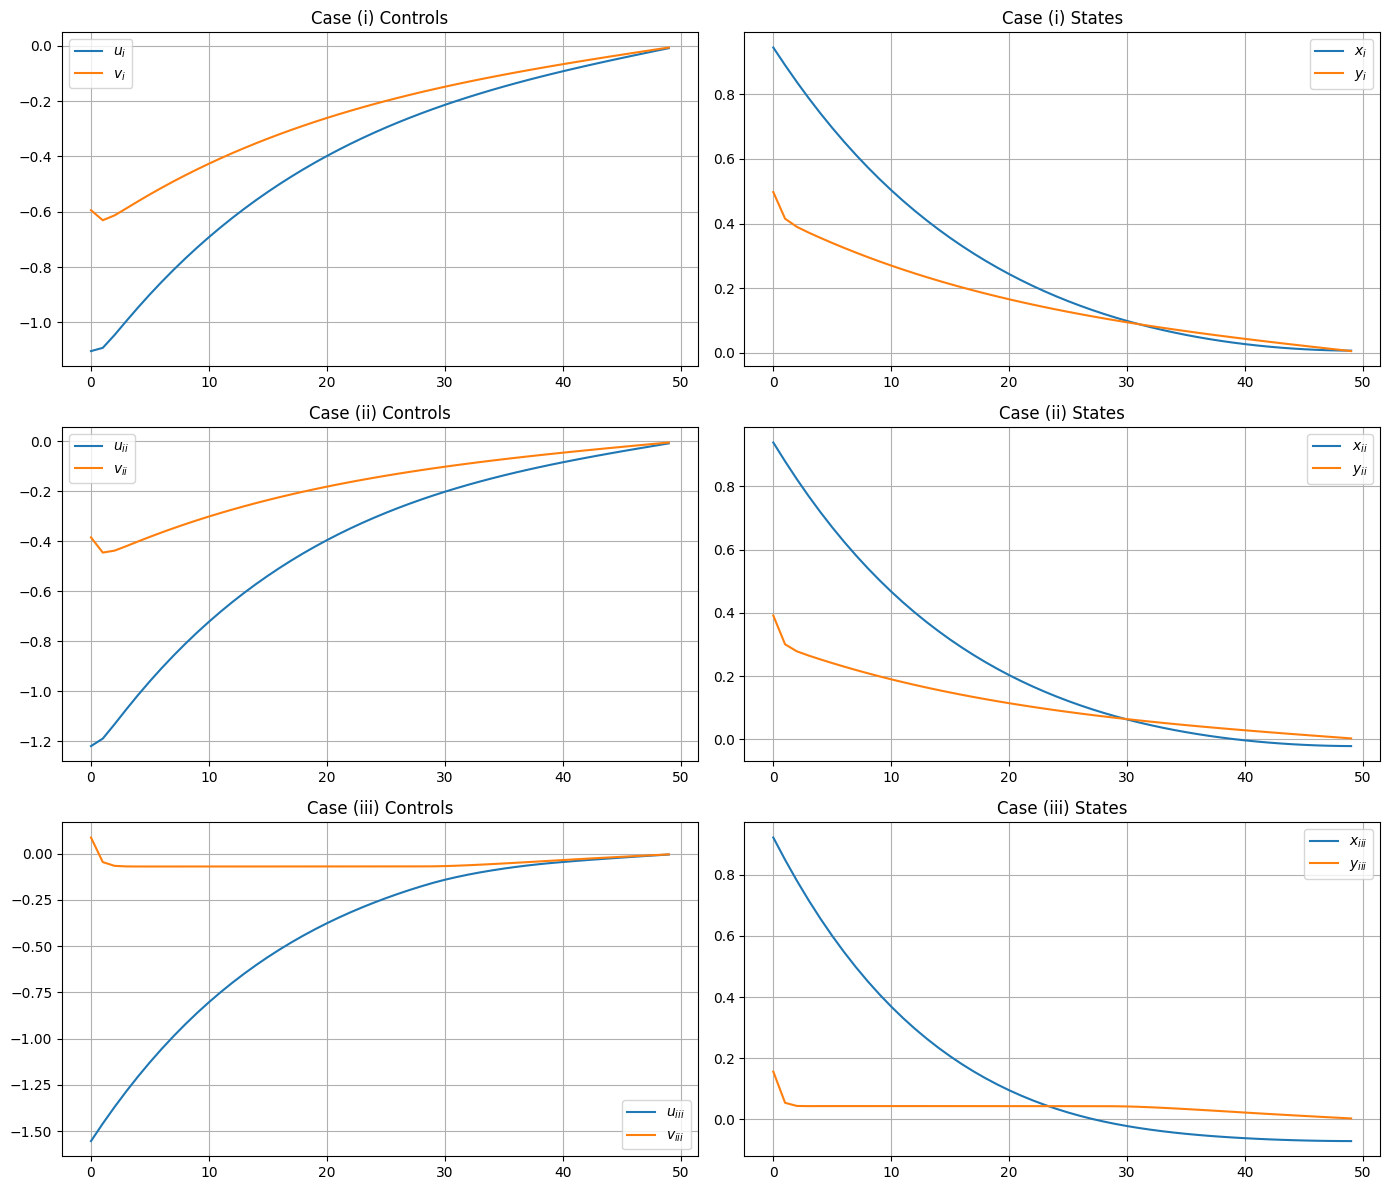

In [12]:
# Parameters
lr = 1e-1  # optimal
n_iter = 10000

# Case i
u_i, v_i = gradient_descent(gamma1=0, gamma2=1, epsilon=1, lr=1e-4, n_iter=10000)
x_i = Sx @ u_i + cx
y_i = Sy @ v_i + cy

# Case ii
u_ii, v_ii = gradient_descent(gamma1=1, gamma2=0, epsilon=1, lr=1e-4, n_iter=10000)
x_ii = Sx @ u_ii + cx
y_ii = Sy @ v_ii + cy

# Case iii
u_iii, v_iii = gradient_descent(gamma1=1, gamma2=0, epsilon=0.1, lr=1e-4, n_iter=10000)
x_iii = Sx @ u_iii + cx
y_iii = Sy @ v_iii + cy

plt.figure(figsize=(14, 12))

# Row 1
plt.subplot(3, 2, 1)
plt.plot(u_i, label=r'$u_i$')
plt.plot(v_i, label=r'$v_i$')
plt.title(r'Case (i) Controls')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(x_i, label=r'$x_i$')
plt.plot(y_i, label=r'$y_i$')
plt.title(r'Case (i) States')
plt.grid(True)
plt.legend()

# Row 2
plt.subplot(3, 2, 3)
plt.plot(u_ii, label=r'$u_{ii}$')
plt.plot(v_ii, label=r'$v_{ii}$')
plt.title(r'Case (ii) Controls')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(x_ii, label=r'$x_{ii}$')
plt.plot(y_ii, label=r'$y_{ii}$')
plt.title(r'Case (ii) States')
plt.grid(True)
plt.legend()

# Row 3
plt.subplot(3, 2, 5)
plt.plot(u_iii, label=r'$u_{iii}$')
plt.plot(v_iii, label=r'$v_{iii}$')
plt.title(r'Case (iii) Controls')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(x_iii, label=r'$x_{iii}$')
plt.plot(y_iii, label=r'$y_{iii}$')
plt.title(r'Case (iii) States')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('plots/L1_combined.png', dpi=600, bbox_inches='tight')
plt.show()